In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from sklearn.metrics import mean_absolute_error, mean_squared_error

import itertools

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Plot defaults
plt.rcParams['figure.figsize'] = (12,5)
plt.rcParams['font.size'] = 12


# Data Preparation and Exploration

In [2]:
df = pd.read_csv('exchange_rate.csv')

print('Columns found:', df.columns.tolist())
print(df.head())

# Try to infer date column and target column
# Assume first column is date and second is USD->AUD rate as per instructions
date_col = df.columns[0]
rate_col = df.columns[1]

# Parse dates and set index
df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
df = df.set_index(date_col).sort_index()

# Rename rate column to a friendly name
df = df.rename(columns={rate_col: 'USD_AUD'})

print('\nData range:', df.index.min(), 'to', df.index.max())
print('Missing values per column:\n', df.isna().sum())


Columns found: ['date', 'Ex_rate']
               date  Ex_rate
0  01-01-1990 00:00   0.7855
1  02-01-1990 00:00   0.7818
2  03-01-1990 00:00   0.7867
3  04-01-1990 00:00   0.7860
4  05-01-1990 00:00   0.7849

Data range: 1990-01-01 00:00:00 to 2010-12-09 00:00:00
Missing values per column:
 USD_AUD    0
dtype: int64


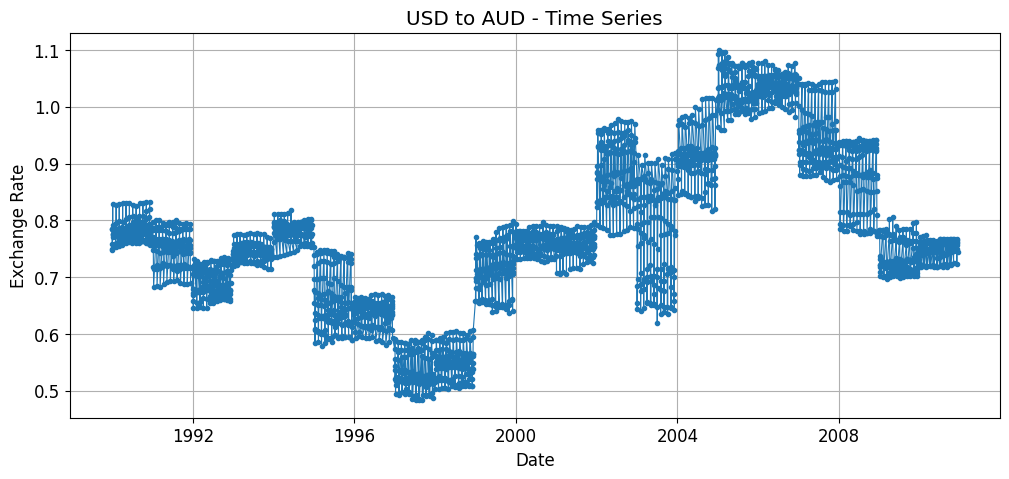

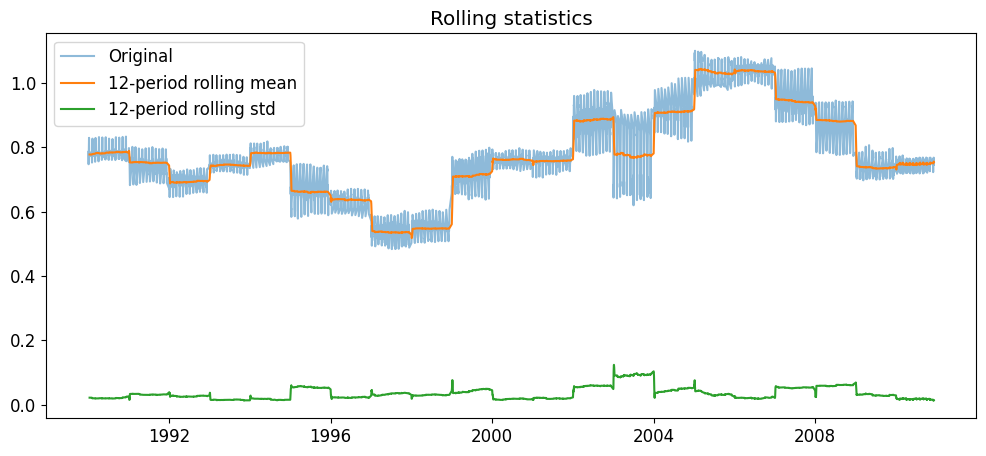

In [3]:
# Initial exploration - plot time series
plt.figure()
plt.plot(df['USD_AUD'], marker='.', linewidth=0.8)
plt.title('USD to AUD - Time Series')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.grid(True)
plt.show()

# Also show a rolling mean and std to inspect trends
rolling_window = 12
plt.figure()
plt.plot(df['USD_AUD'], label='Original', alpha=0.5)
plt.plot(df['USD_AUD'].rolling(window=rolling_window).mean(), label=f'{rolling_window}-period rolling mean')
plt.plot(df['USD_AUD'].rolling(window=rolling_window).std(), label=f'{rolling_window}-period rolling std')
plt.legend()
plt.title('Rolling statistics')
plt.show()


Total missing before: 0
Total missing after: 4590


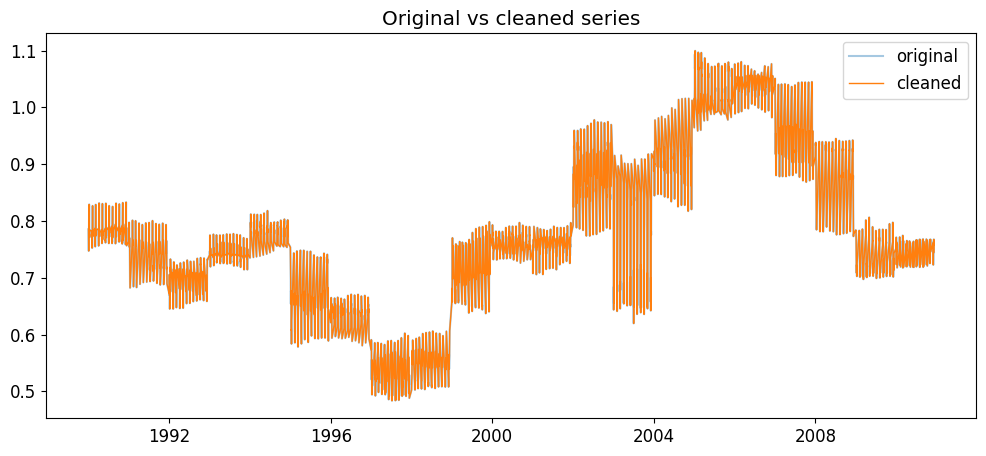

In [4]:
# Handle missing values and anomalies
print('Total missing before:', df['USD_AUD'].isna().sum())

# Simple strategies: linear interpolation + forward/backward fill
# You may choose different approaches depending on the nature of gaps
s = df['USD_AUD'].copy()

# Remove rows with NaT in the index
s = s[s.index.notna()]

# 1.If tiny fraction missing, interpolate
if s.isna().mean() < 0.2:
    s = s.interpolate(method='time')
    s = s.fillna(method='bfill').fillna(method='ffill')
else:
    # If many missing, inform the user and use forward fill as fallback
    print('Large fraction missing — check data source. Using forward fill/backfill fallback.')
    s = s.fillna(method='ffill').fillna(method='bfill')

# 2.Winsorize or cap extreme outliers (optional)
# We'll identify points outside mean +/- 4*std and replace with nearest bound
mu = s.mean()
sigma = s.std()
lower_bound = mu - 4*sigma
upper_bound = mu + 4*sigma
s_clipped = s.clip(lower=lower_bound, upper=upper_bound)

# Replace in dataframe and report
df['USD_AUD_clean'] = s_clipped
print('Total missing after:', df['USD_AUD_clean'].isna().sum())

plt.figure()
plt.plot(df['USD_AUD'], alpha=0.4, label='original')
plt.plot(df['USD_AUD_clean'], label='cleaned', linewidth=1)
plt.legend()
plt.title('Original vs cleaned series')
plt.show()

No inferred freq. Resampling to monthly frequency using mean() — change if you know true frequency.


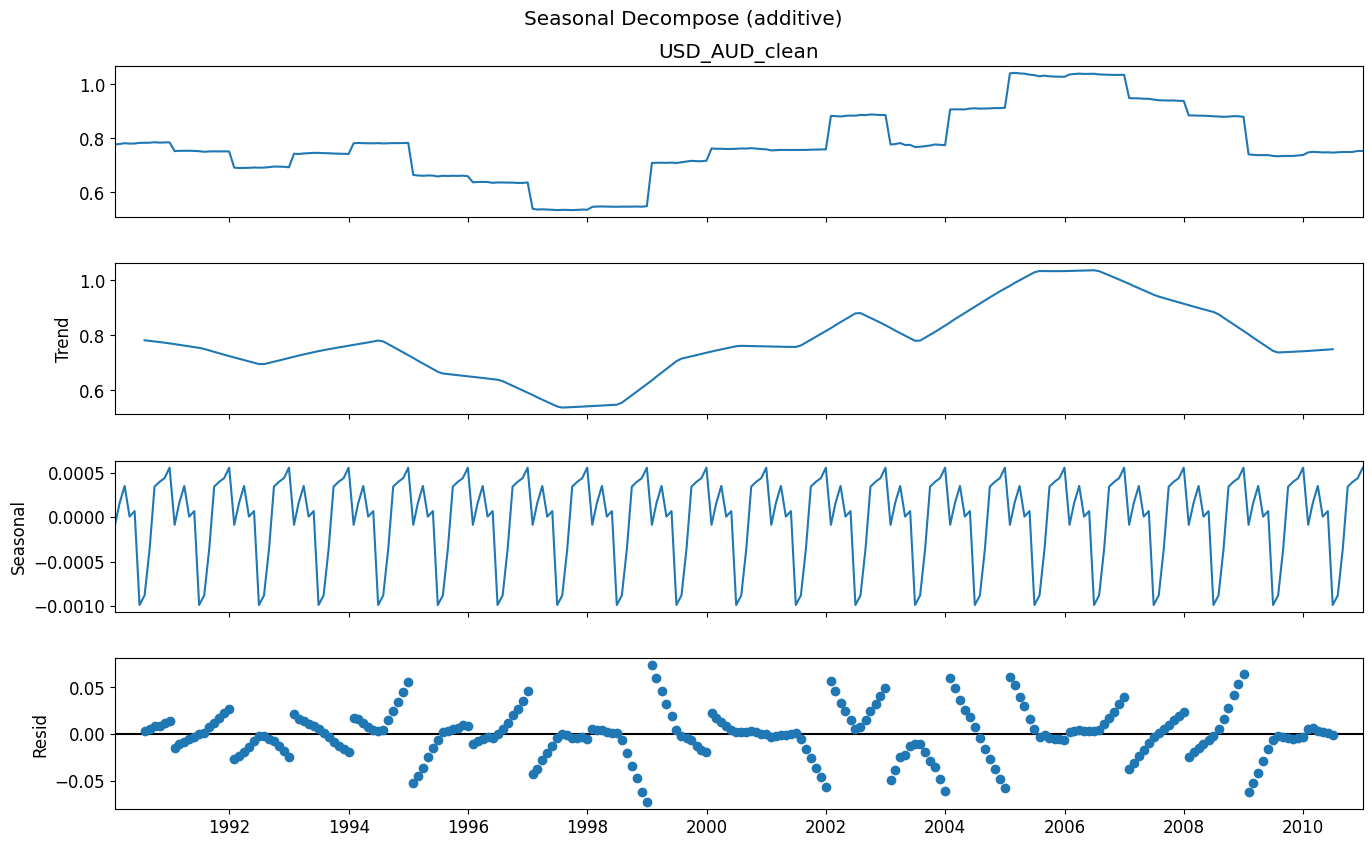

In [5]:
# Decomposition(trend/seasonal/resid) - only for regular frequency
# If data is not strictly regular, resample to monthly (or appropriate) frequency.

# Try to infer frequency. If index has a frequency, use it; otherwise resample to monthly mean
if df.index.inferred_freq is None:
    print('No inferred freq. Resampling to monthly frequency using mean() — change if you know true frequency.')
    series = df['USD_AUD_clean'].resample('M').mean()
else:
    series = df['USD_AUD_clean']

# Decompose with multiplicative or additive depending on scale (try additive)
try:
    decomposition = seasonal_decompose(series.dropna(), model='additive', period=None)
    fig = decomposition.plot()
    fig.set_size_inches(14,9)
    plt.suptitle('Seasonal Decompose (additive)')
    plt.show()
except Exception as e:
    print('Decomposition failed:', e)


In [6]:
# Stationarity check - rolling stats + ADF test

from statsmodels.tsa.stattools import adfuller
print('Performing ADF test...')
res_adf = adfuller(series.dropna())
print('ADF Statistic:', res_adf[0])
print('p-value:', res_adf[1])

# If p-value > 0.05 -> non-stationary -> differencing needed

Performing ADF test...
ADF Statistic: -1.476085070095419
p-value: 0.5453068067504618


# Part 2: ARIMA Model Building
We begin by checking stationarity using the ADF test, then analyze the ACF and PACF plots to estimate ARIMA parameters (p, d, q). We perform a grid search to find the optimal order based on AIC, fit the model, and perform residual diagnostics to check adequacy. We then forecast future exchange rates and compare with actual values.

<Figure size 1200x500 with 0 Axes>

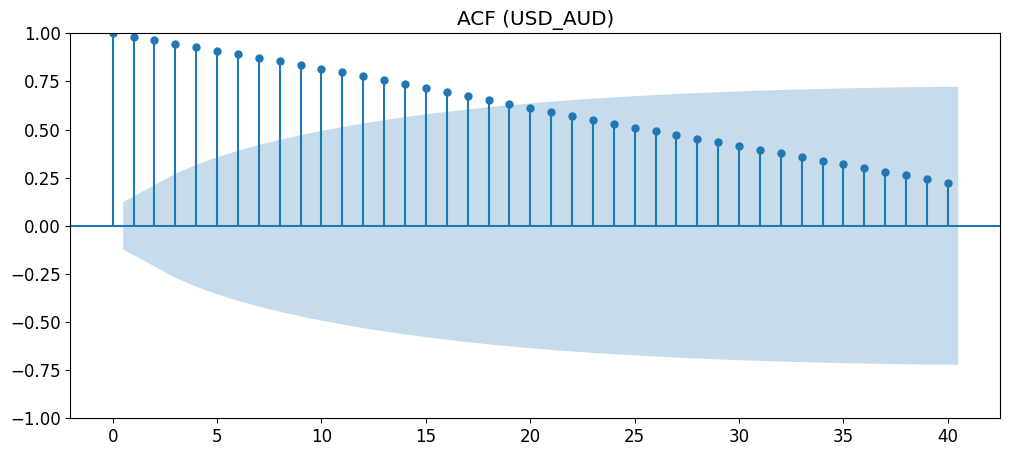

<Figure size 1200x500 with 0 Axes>

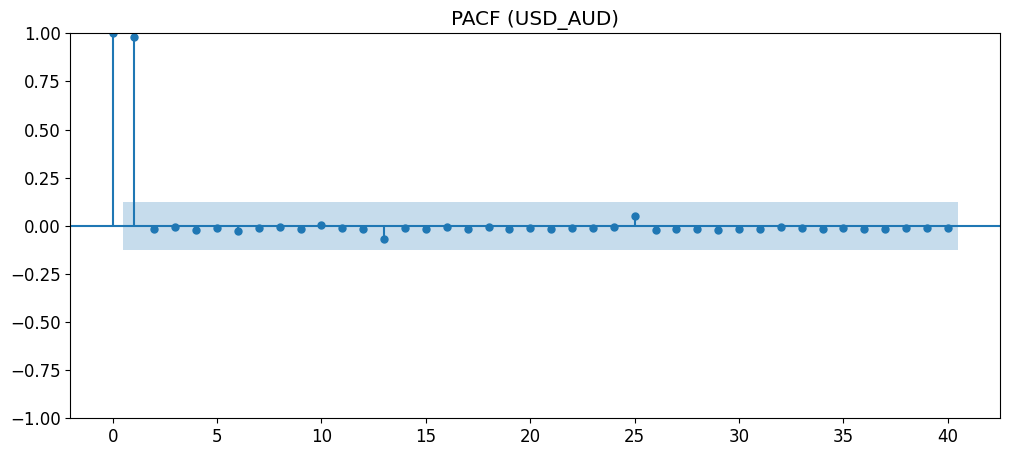

In [7]:
# ACF and PACF plots to guide ARIMA choice
plt.figure()
plot_acf(series.dropna(), lags=40)
plt.title('ACF (USD_AUD)')
plt.show()

plt.figure()
plot_pacf(series.dropna(), lags=40, method='ywm')
plt.title('PACF (USD_AUD)')
plt.show()


Train length: 240 Test length: 12


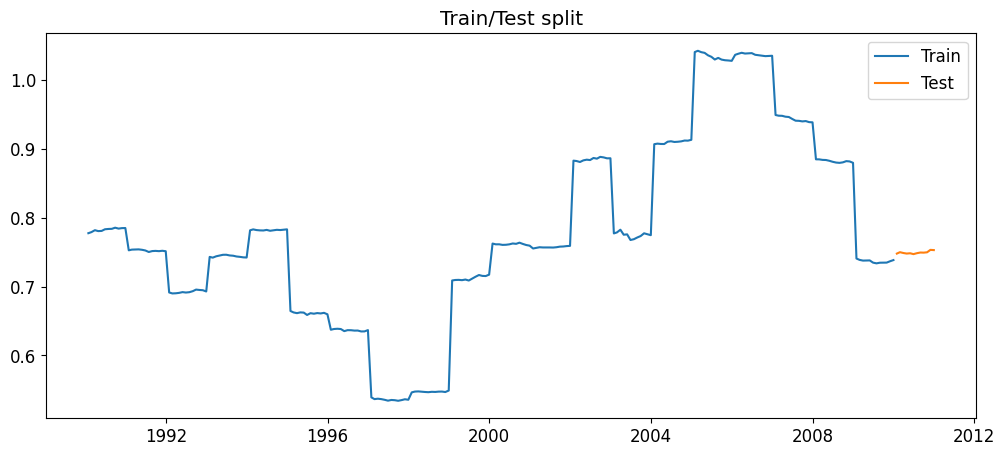

In [8]:
# Prepare train/test split
# We'll use the last 12 periods as test if resampled monthly; otherwise 20% holdout
if series.index.freqstr in (None, '') or 'M' in str(series.index.freq):
    # if monthly or unknown -> use last 12
    n_test = 12
else:
    n_test = max(12, int(0.2*len(series)))

series = series.dropna()
train, test = series[:-n_test], series[-n_test:]
print('Train length:', len(train), 'Test length:', len(test))

plt.figure()
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.legend()
plt.title('Train/Test split')
plt.show()


In [9]:
# ARIMA parameter grid search (p,d,q) using AIC
# We'll try small ranges to keep runtime reasonable. Adjust ranges for more thorough search.
import math

p = range(0,4)
d = range(0,3)
q = range(0,4)

best_aic = np.inf
best_order = None
best_model = None

for order in itertools.product(p,d,q):
    try:
        model = ARIMA(train, order=order)
        fitted = model.fit()
        if fitted.aic < best_aic:
            best_aic = fitted.aic
            best_order = order
            best_model = fitted
    except Exception:
        continue

print('Best ARIMA order by AIC:', best_order, 'AIC:', best_aic)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used

Best ARIMA order by AIC: (1, 0, 0) AIC: -1079.9497271570974


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:          USD_AUD_clean   No. Observations:                  240
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 542.975
Date:                Mon, 11 Aug 2025   AIC                          -1079.950
Time:                        17:22:38   BIC                          -1069.508
Sample:                    01-31-1990   HQIC                         -1075.742
                         - 12-31-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7784      0.095      8.222      0.000       0.593       0.964
ar.L1          0.9827      0.012     79.172      0.000       0.958       1.007
sigma2         0.0006   1.86e-05     33.558      0.0

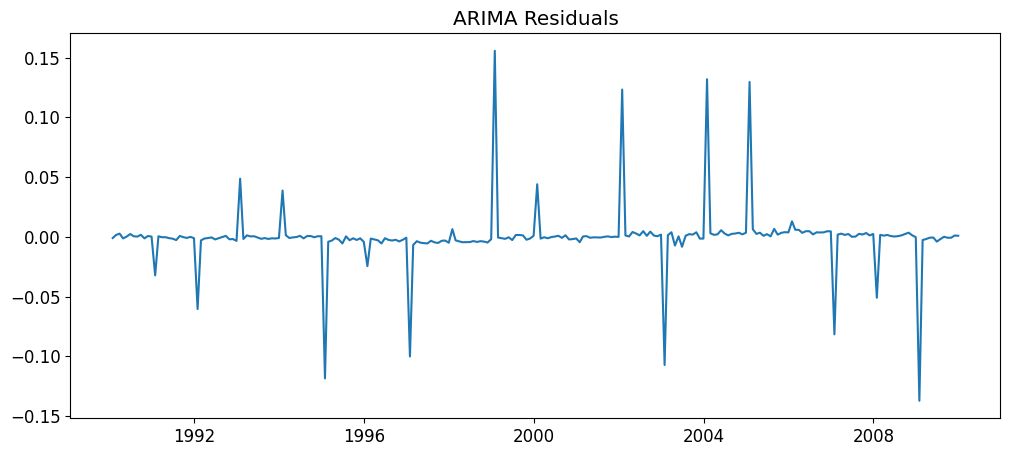

<Figure size 1200x500 with 0 Axes>

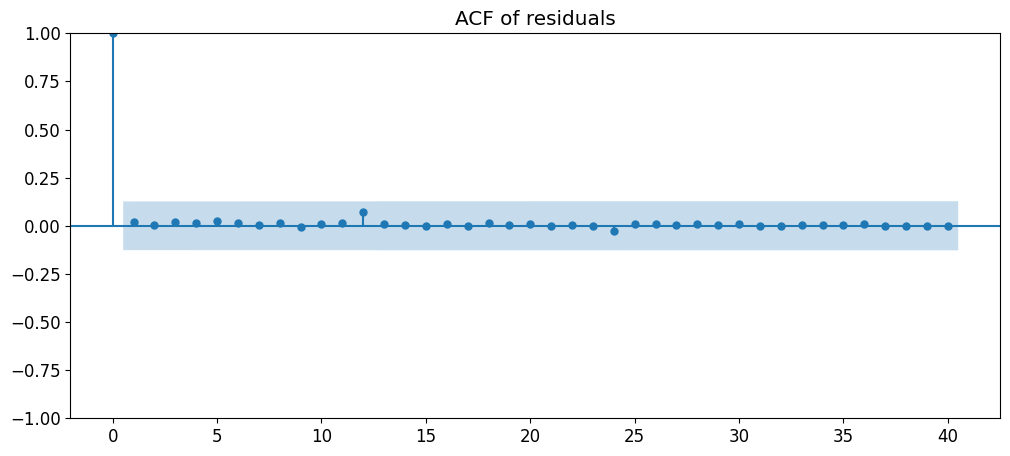

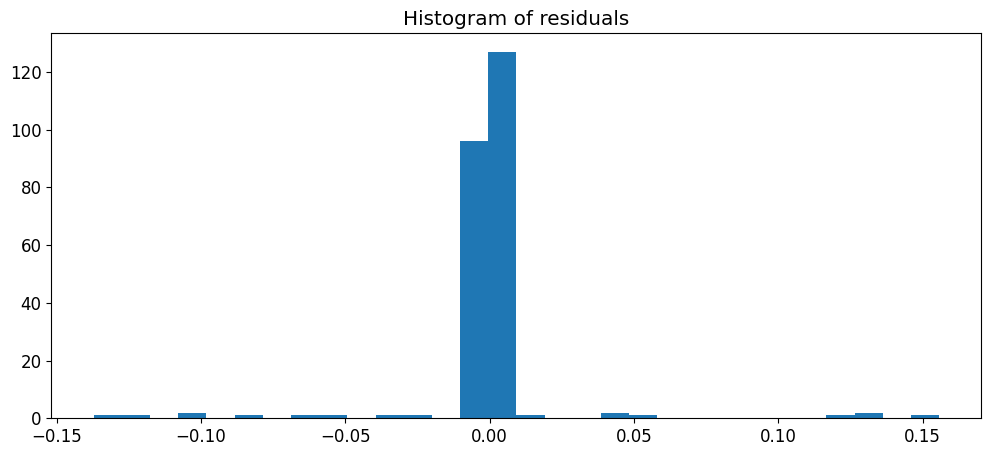

In [10]:
# Diagnostics of the chosen ARIMA model
if best_model is None:
    raise RuntimeError('ARIMA grid search failed to fit any model. Try broader/narrower ranges or check data.')

print(best_model.summary())

# Residual diagnostics
resid = best_model.resid
plt.figure()
plt.plot(resid)
plt.title('ARIMA Residuals')
plt.show()

plt.figure()
plot_acf(resid.dropna(), lags=40)
plt.title('ACF of residuals')
plt.show()

# Histogram of residuals
plt.figure()
plt.hist(resid.dropna(), bins=30)
plt.title('Histogram of residuals')
plt.show()


# Part 3: Exponential Smoothing Model Building
Here, we explore different exponential smoothing approaches: Simple (SES), Holt's linear trend, and Holt-Winters seasonal models. We choose seasonal periods based on data frequency and fit each model. We then forecast using each model and visualize results.

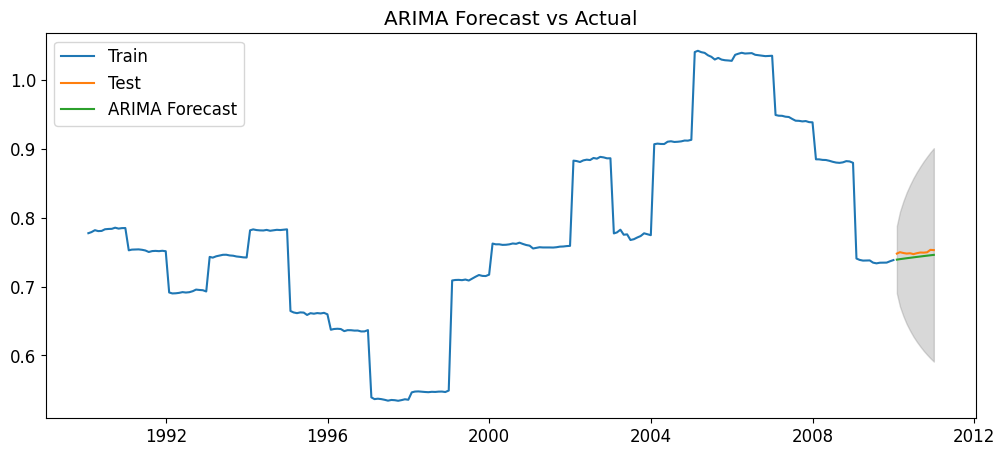

In [11]:
# ARIMA forecasting and plotting
# Forecast n_test steps ahead and compare with actual test
arima_forecast_res = best_model.get_forecast(steps=n_test)
arima_pred = arima_forecast_res.predicted_mean
arima_ci = arima_forecast_res.conf_int()

plt.figure()
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(arima_pred.index, arima_pred, label='ARIMA Forecast')
plt.fill_between(arima_ci.index, arima_ci.iloc[:,0], arima_ci.iloc[:,1], color='gray', alpha=0.3)
plt.legend()
plt.title('ARIMA Forecast vs Actual')
plt.show()

In [12]:
# Exponential Smoothing model selection and fitting
# Try three models: Simple, Holt (linear trend), Holt-Winters (trend+seasonality if needed)

# Choose seasonal periods if series is monthly
seasonal_periods = 12 if series.index.inferred_freq is None or 'M' in str(series.index.freq) else 1

es_models = {}

# 1.Simple Exponential Smoothing (no trend, no seasonality)
try:
    ses = ExponentialSmoothing(train, trend=None, seasonal=None)
    ses_fit = ses.fit(optimized=True)
    es_models['SES'] = ses_fit
except Exception as e:
    print('SES failed:', e)

# 2.Holt's Linear (trend only)
try:
    holt = ExponentialSmoothing(train, trend='add', seasonal=None)
    holt_fit = holt.fit(optimized=True)
    es_models['Holt'] = holt_fit
except Exception as e:
    print('Holt failed:', e)

# 3.Holt-Winters (additive seasonality assumed)
try:
    hw_add = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=seasonal_periods)
    hw_add_fit = hw_add.fit(optimized=True)
    es_models['HoltWinters_add'] = hw_add_fit
except Exception as e:
    print('Holt-Winters additive failed:', e)

Holt-Winters additive failed: seasonal_periods must be larger than 1.


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


# Part 4: Model Evaluation and Comparison
We compute MAE, RMSE, and MAPE for each model to evaluate accuracy. Finally, we compare models visually and numerically, and select the best-performing model. Based on these metrics, we draw conclusions on which method is most suitable for forecasting USD to AUD rates in this dataset.

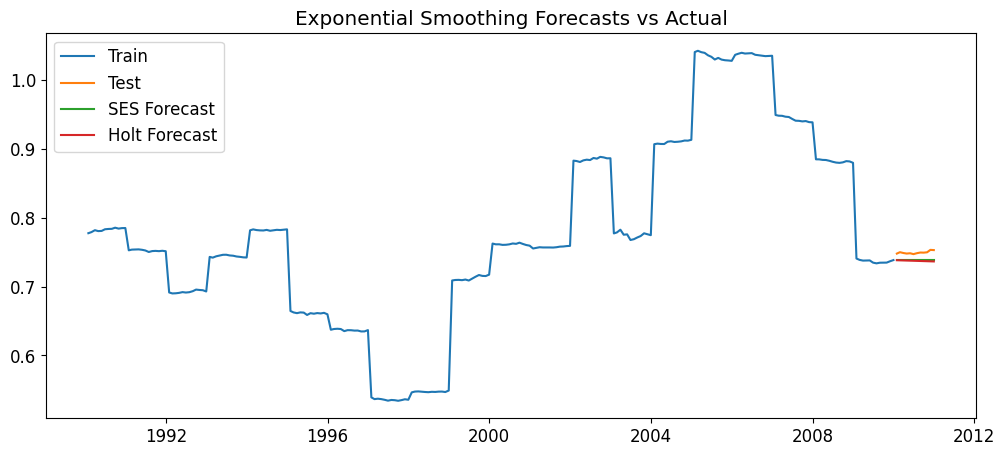

In [13]:
# Forecast with ES models and plot
es_forecasts = {}
for name, fit in es_models.items():
    pred = fit.forecast(steps=n_test)
    es_forecasts[name] = pred

plt.figure()
plt.plot(train, label='Train')
plt.plot(test, label='Test')
for name, pred in es_forecasts.items():
    plt.plot(pred.index, pred, label=f'{name} Forecast')
plt.legend()
plt.title('Exponential Smoothing Forecasts vs Actual')
plt.show()

In [14]:
# Evaluation metrics for all models

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # avoid division by zero
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

results = []

# ARIMA metrics
arima_pred_aligned = arima_pred.reindex(test.index)
results.append(('ARIMA',
                mean_absolute_error(test, arima_pred_aligned),
                np.sqrt(mean_squared_error(test, arima_pred_aligned)),
                mape(test, arima_pred_aligned)))

# ES metrics
for name, pred in es_forecasts.items():
    pred_aligned = pred.reindex(test.index)
    results.append((name,
                    mean_absolute_error(test, pred_aligned),
                    np.sqrt(mean_squared_error(test, pred_aligned)),
                    mape(test, pred_aligned)))

results_df = pd.DataFrame(results, columns=['Model','MAE','RMSE','MAPE']).set_index('Model')
print('\nEvaluation metrics on test set:')
print(results_df)



Evaluation metrics on test set:
            MAE      RMSE      MAPE
Model                              
ARIMA  0.006743  0.006938  0.899605
SES    0.010967  0.011119  1.462832
Holt   0.012025  0.012235  1.603876


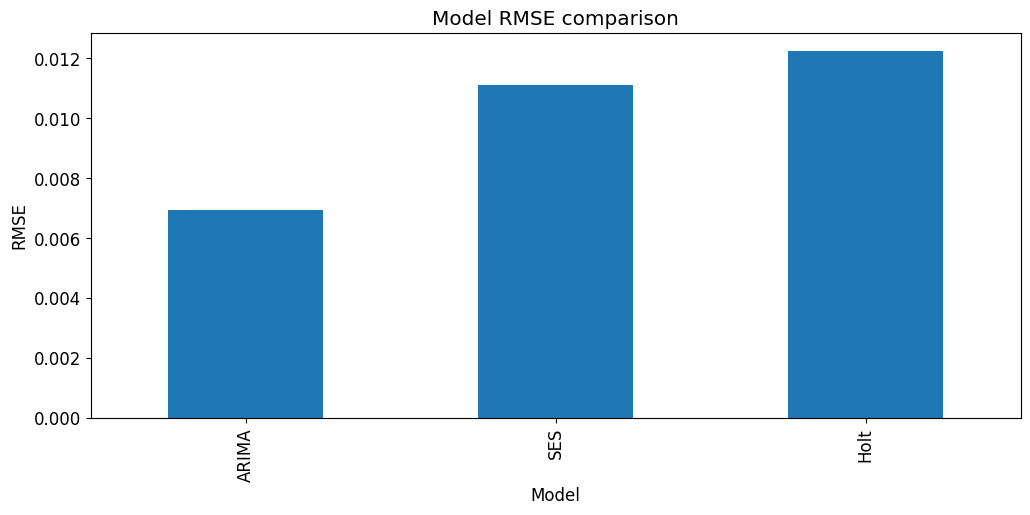

Best model by RMSE: ARIMA

Analysis complete. Review the plots and metrics to justify model selection.



In [15]:
# Final comparison plots and conclusion
# Bar plot of RMSE for quick comparison
results_df[['RMSE']].plot(kind='bar', legend=False)
plt.title('Model RMSE comparison')
plt.ylabel('RMSE')
plt.show()

# Print best model by RMSE
best_by_rmse = results_df['RMSE'].idxmin()
print(f"Best model by RMSE: {best_by_rmse}")

# Save results and models if desired
results_df.to_csv('forecast_evaluation_metrics.csv')

print('\nAnalysis complete. Review the plots and metrics to justify model selection.\n')

- If data frequency is daily with many observations, consider resampling to weekly or monthly to remove noise.
- Consider using pmdarima's auto_arima for automated ARIMA order selection if available (pip install pmdarima).
- For non-linear patterns consider using machine learning approaches (Random Forest, XGBoost) on lag features or deep learning (LSTM).
- If there is strong seasonality and exogenous variables (e.g., interest rate changes), consider SARIMAX with exogenous variables.
- Grid search ranges used for ARIMA were intentionally small to limit runtime. Expand ranges for production experiments.